In [1]:
%pylab qt
import scipy.integrate as integrate
from IPython import display

Populating the interactive namespace from numpy and matplotlib


In [2]:
# solve_ivp functions

# returns vector of dx/dt, dAcx/dt and dAx/dt in that order

def derivs(t, y, nu, xs, w0, d):
    x0 = y[0]               # position of hub
    N = int(0.5*(len(y)-1))   # of lattice sites
    Acx = y[1:N+1]          # bound complex on lattice
    Ax = y[-N:]             # free complex on lattice
    
    
    eps = 1e-8
    jj = where(Acx < eps)[0] # check where Acx is very small (and will log(Acx) be a problem)
    Acx_temp = Acx.copy()    # make a temporary copy to change, so that Acx does not need to be changed
    Acx_temp[jj] = 1e-10      
    err = (log(eps)-log(Acx_temp))
    

    wr = zeros(N)
    ii = where(err < 0.0)[0]
    wr[ii] = w0*Acx[ii]
    force_unbinding = wr * exp(abs(x0 - xs) * d)
    
    
    
    dxcdt = integrate.trapz(-(x0-xs)*Acx, x=xs)  # force equation
    binding = exp(-0.5*(x0-xs)**2)*Ax 
    burnt = nu*Acx
    

    dAcxdt = (binding - burnt - force_unbinding)   # complex chemistry
    dAxdt = -binding + force_unbinding           # free substrate chemistry
    
    return array( [dxcdt] + list(dAcxdt) + list(dAxdt))     # maybe a better way to put them all together

In [3]:
# define event as having gone to x = 20.0
def event(t, y):
    x0 = y[0]
        
    return 10.0-x0

event.direction = 0        
event.terminal = True     # stop solver if event satisfied

In [13]:
# use solve_ivp to find solution from t0=0 up to a max tf= 400, but stop if x hits x=20.0

# parameters - just 2 params in this model
tf = 400.0

w_n = 10
delta_n = 9

ws = concatenate((zeros(1),logspace(-4, 1, w_n, base=2)))

print(ws)

deltas = linspace(0.1, 0.9, delta_n)
#deltas = ones(1)*0.69
#delta_n = len(deltas)
print(deltas)

# define domain and lattice
Lmax = 20.0
Lmin = -5.0
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)


[0.         0.0625     0.09185841 0.13500747 0.19842513 0.29163226
 0.42862199 0.62996052 0.92587471 1.36079    2.        ]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [14]:
#I.C.

a0 = 1.0
nu = 0.5

sol_a0 = []  # record final speed

for delta in deltas:
    
    A0x = zeros(Nx)
    A0x[xs > 0.0] = a0

    # iterate over params
    sol_nu  = []
    for w in ws:
        print(w, delta)

        x0 = 0.0
        Ax = 1.0*A0x
        Acx = zeros(Nx)

        # initial conditions for all the equations, y0
        y0 = array([x0] + list(Acx) + list(Ax))
        
        

        sol = integrate.solve_ivp(lambda t, y: derivs(t, y, nu, xs,w, delta), (0., tf), y0, events=[event], method='BDF')

        v_final = derivs(sol.t[-1], sol.y[:,-1], nu, xs, w, delta)[0]  #dx/dt
        
        Acxf = sol.y[1:1+Nx,-1]  # final amount of complex
        btot = integrate.trapz(nu*Acxf, x=xs)    # total rate of burnt at final time
        
        xp_vals = sol.y[0]
        x_vals = xs
        t_vals = sol.t
        Ac_vals = sol.y[1:Nx+1]
        As_vals = sol.y[Nx+1:]


        vs = []
        for i in range(len(t_vals)):
            v = derivs(0.,sol.y[:,i], nu, xs, w, delta)[0]
            vs.append(v)
        check = 0

        efficiency = v_final**2 / (btot)
        
        
        sol_nu.append([efficiency, t_vals, x_vals, vs, Ac_vals, As_vals, xp_vals, btot])
    sol_a0.append(sol_nu)

0.0 0.1
0.0625 0.1
0.09185840576722491 0.1
0.13500746736153826 0.1
0.19842513149602498 0.1
0.2916322598940292 0.1
0.4286219914265364 0.1
0.6299605249474366 0.1
0.9258747122872907 0.1
1.3607900001743771 0.1
2.0 0.1
0.0 0.2
0.0625 0.2
0.09185840576722491 0.2
0.13500746736153826 0.2
0.19842513149602498 0.2
0.2916322598940292 0.2
0.4286219914265364 0.2
0.6299605249474366 0.2
0.9258747122872907 0.2
1.3607900001743771 0.2
2.0 0.2
0.0 0.30000000000000004
0.0625 0.30000000000000004
0.09185840576722491 0.30000000000000004
0.13500746736153826 0.30000000000000004
0.19842513149602498 0.30000000000000004
0.2916322598940292 0.30000000000000004
0.4286219914265364 0.30000000000000004
0.6299605249474366 0.30000000000000004
0.9258747122872907 0.30000000000000004
1.3607900001743771 0.30000000000000004
2.0 0.30000000000000004
0.0 0.4
0.0625 0.4
0.09185840576722491 0.4
0.13500746736153826 0.4
0.19842513149602498 0.4
0.2916322598940292 0.4
0.4286219914265364 0.4
0.6299605249474366 0.4
0.9258747122872907 0.4

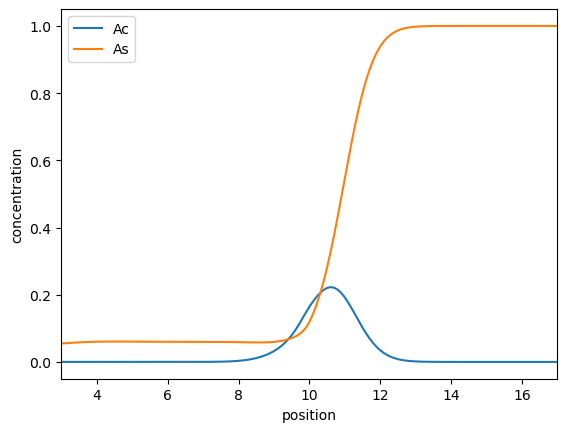

In [23]:
#plot concentration vs. position for a given a0
#sol_factor.append([efficiency, t_vals, x_vals, vs, Ac_vals, As_vals, xp_vals, btot])

for w_index in range(0,w_n,2):
    for delta_index in range(0,delta_n,3):
        sol = sol_a0[w_index][delta_index] 
        for i in range(0,len(sol[1]),1):
            
            #sol[0]: efficiency, sol[1]: t_vals, sol[2]: x_vals
            xp = round(sol[6][i],2)
            v = round(sol[3][i],2)
            t = round(sol[1][i],2)
            xp_index = int(xp)
            rad = 7.0
            display.clear_output(wait=True)
            plot(sol[2],sol[4][:,i], label = "Ac")
            plot(sol[2],sol[5][:,i], label = "As")
            #title("Concentration vs. Position")
            #text(xp-rad, 0.05, 'v: '+ str(v) +"  x: "+ str(xp) + "  t: " + str(t))
            #text(xp-rad, 0.1, 'w: '+ str(round(ws[w_index],2)) +"  delta: "+ str(round(deltas[delta_index],2)))
            xlabel("position")
            xlim([xp-rad, xp+rad])
            ylabel("concentration")
            #input("Press enter to continue")
            legend()

            display.display(gcf())
            cla()

In [20]:
eff = []
for delta_index in range(delta_n):
    eff_d = []
    for w_index in range(w_n+1):
        sol = sol_a0[delta_index][w_index] 
        eff_d.append(sol[3][-1])
    plot(ws, eff_d,".-", label = r"$\delta$: " + str(round(deltas[delta_index],2)))
    xlabel(r"$\omega'$")
    ylabel(r"$\eta$")
    #title(r"For typical values of $a_{tot}$ and $\nu'$")
    eff.append(eff_d)
    legend()


In [23]:
for w_index in range(w_n):
    for delta_index in range(0,delta_n,4):
        sol = sol_a0[w_index][delta_index] 
        plot(sol[1],sol[3], label = r"$\delta$: " + str(round(deltas[delta_index],2)))
    legend()
